In [1]:
# importing needed packages here

import os
import re
import spacy
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns

from autocorrect import Speller
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from spacy.matcher import Matcher
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Context

Bank BPIA (Banco Português de Inteligência Artificial) believes that AI has a great potential to transform organizations and challenge partners with the same mindset. A task force was born with the goal of researching techniques, methodologies and, in general, developing AI and advanced analytics projects.

Last week, the Bank proposed to the task force to study how AI can be used to identify the goal of Customers’ emails. This project aims to respond quickly and accurately to their questions and concerns. 

LDSA recommended you and your team! Congratulations, you’re in!!

# Objective

In this Hackathon, you will try to classify emails from the customers! You will do this by analyzing the body of several emails, and trying to predict the class they belong to.

You will be given a dataset that includes: the date, language and body (“text”) of the emails in English only. The dataset was manually annotated by people with business knowledge. Each email has a label that corresponds to one of the 77 categories used by the Bank. These 77 categories have been grouped into 5 classes that link directly to specific Bank procedures. Mapping is provided in file mapping.csv.

This is a multi-class problem with unstructured data, we'll ask you to use a mean of all the per-class F1 scores (hint: there's a super easy way to do this with the libraries you already use). We suggest that you look and dedicate enough time to studying the data carefully. 

# Importing the data

In [41]:
#Loading the required data
data_path = "data/dataset.csv"
maping_path = "data/mapping.csv"
df = pd.read_csv(data_path)

# Create class feature using dictionary created from mapping dataset
mapping_dict = pd.read_csv(maping_path).set_index('category').to_dict()['class']
df['class'] = df.category.map(mapping_dict)

<AxesSubplot:>

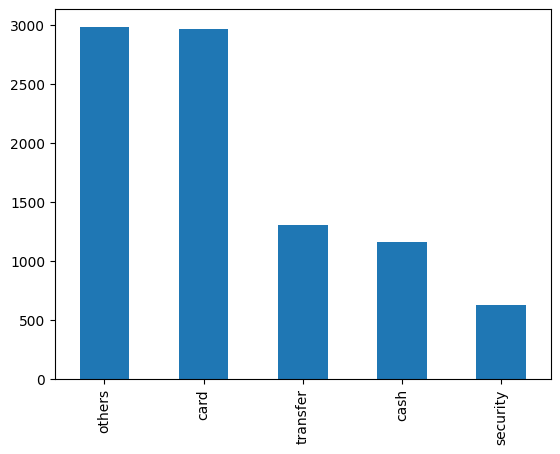

In [3]:
# Create dataset only for englixh language
# Looking at the distribution of class feature for english language
df_en = df.loc[df.language == 'en']
df_en['class'].value_counts().plot.bar()

In [5]:
df_en.loc[df_en['class'].isna()]

text      date  \
24          We have hope. Rebellions are built on hope.  2-2-2022   
1155  I'm one with the Force, and the Force will gui...  2-2-2022   
1305  Lesson one from this experience: Realize how m...  2-2-2022   
1459  The belonging you seek is not behind you; it i...  2-2-2022   
2023     I am one with the Force. The Force is with me.  2-2-2022   
2107            Try not. Do or do not. There is no try.  2-2-2022   
2176                    That's not how the Force works!  2-2-2022   
2222                         No one’s ever really gone.  2-2-2022   
2412                            Never tell me the odds!  2-2-2022   
2453                  I'll never turn to the dark side.  2-2-2022   
2829                     Don't underestimate the Force.  2-2-2022   
3381  We fight for justice because justice is the fu...  2-2-2022   
3392  No longer certain that one ever does win a war...  2-2-2022   
3415  Once you start down the dark path, forever wil...  2-2-2022   
3419  For my ally is the Force, and a powerful ally ...  2-2-2022   
3869          Let the past die. Kill it if you have to.  2-2-2022   
4418       Your eyes can deceive you; don’t trust them.  2-2-2022   
4715  Train yourself to let go of everything you fea...  2-2-2022   
5382     I know how to run without you holding my hand!  2-2-2022   
5542  We’ll always be with you. No one’s ever really...  2-2-2022   
5646  The ability to speak does not make you intelli...  2-2-2022   
5764                Your focus determines your reality.  2-2-2022   
5852  Now I know there is something strong than fear...  2-2-2022   
5977  Who’s the more foolish: the fool or the fool w...  2-2-2022   
6099                         May the Force be with you.  2-2-2022   
6756            Sometimes to heal, you must first hurt.  2-2-2022   
6818            Reality doesn’t care if you believe it.  2-2-2022   
7109  In a dark place we find ourselves and a little...  2-2-2022   
7329  Authority can be given, but leadership must be...  2-2-2022   
7431  Rule 23: Never pull sentry duty on an empty st...  2-2-2022   
7575     Luminous beings we are, not this crude matter.  2-2-2022   
8353            You must unlearn what you have learned.  2-2-2022   
8689  Sometimes we must let go of our pride and do w...  2-2-2022   
8877                Your focus determines your reality.  2-2-2022   
8928  Close your eyes. Feel it. The light...it's alw...  2-2-2022   

             category language class  
24    account_support       en   NaN  
1155  account_support       en   NaN  
1305  account_support       en   NaN  
1459  account_support       en   NaN  
2023  account_support       en   NaN  
2107  account_support       en   NaN  
2176  account_support       en   NaN  
2222  account_support       en   NaN  
2412  account_support       en   NaN  
2453  account_support       en   NaN  
2829  account_support       en   NaN  
3381  account_support       en   NaN  
3392  account_support       en   NaN  
3415  account_support       en   NaN  
3419  account_support       en   NaN  
3869  account_support       en   NaN  
4418  account_support       en   NaN  
4715  account_support       en   NaN  
5382  account_support       en   NaN  
5542  account_support       en   NaN  
5646  account_support       en   NaN  
5764  account_support       en   NaN  
5852  account_support       en   NaN  
5977  account_support       en   NaN  
6099  account_support       en   NaN  
6756  account_support       en   NaN  
6818  account_support       en   NaN  
7109  account_support       en   NaN  
7329  account_support       en   NaN  
7431  account_support       en   NaN  
7575  account_support       en   NaN  
8353  account_support       en   NaN  
8689  account_support       en   NaN  
8877  account_support       en   NaN  
8928  account_support       en   NaN

In [43]:
# remove the missing values
df_en_no_na = df_en.dropna()
df_en_no_na

text        date  \
0     Hello, Does it matter iff I use Visa or Master...    7-6-2022   
1     Good afternoon, I just got refunded for my pur...  16-11-2022   
2           Hello, I got billed ann extra pound! Thanks   4-12-2022   
3     Hi, How long does it take for a transfer to sh...  23-11-2022   
4     hi, When can I use money sent to my accountt? ...   17-4-2022   
...                                                 ...         ...   
9370  good afternoon, I think someone may be using m...   22-6-2022   
9371  good morning, Help, I need to top up my accoun...    7-4-2022   
9372  hi, I made an international purchasee, but the...   7-12-2022   
9373     hi, Why is my card not working anymore? Thanks   1-11-2022   
9374  Hello, How many different cards can I havee fo...   24-4-2022   

                              category language     class  
0                   visa_or_mastercard       en      card  
1               reverted_card_payment?       en      card  
2            extra_charge_on_statement       en    others  
3                      transfer_timing       en  transfer  
4                      transfer_timing       en  transfer  
...                                ...      ...       ...  
9370                  compromised_card       en      card  
9371          top_up_by_cash_or_cheque       en      cash  
9372  card_payment_wrong_exchange_rate       en      card  
9373                  card_not_working       en      card  
9374                getting_spare_card       en      card  

[9038 rows x 5 columns]

# Loading spacy

In [7]:
nlp = spacy.load('en_core_web_sm')

# here upload stopwords from nltk but it can be from spacy
# you can also add or remove stopwords
# Adding single token as stopword → nlp.Defaults.stop_words.add(“perfect”)
# Adding multiple tokens → nlp.Defaults.stop_words|={“hot”,”cobb”}

# Removing single token →nlp.Defaults.stop_words.remove(“what”)
# Removing multiple tokens → nlp.Defaults.stop_words -= {“who”, “when”}

en_stopwords = nlp.Defaults.stop_words

new_stopwords = ["good",
                 'hello',
                 'regard',
                 'hi',
                 'best',
                 'afternoon',
                 'even',
                 'morn',
                 'thank']

for new_words in new_stopwords:
    en_stopwords.add(new_words)
    
#for ww in common_keys:
    #en_stopwords.remove(ww)

In [8]:
"hello" in en_stopwords 

True

# Text Cleaning

In [11]:
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string

def _clean_sentence(sentence):
    tokenizer = WordPunctTokenizer()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    regex_list = [("<[^>]*>", "")
                ]
    # Replace given regexes
    for regex in regex_list:
        sentence = re.sub(regex[0], regex[1], sentence)
        
    # lowercase
    sentence = sentence.lower()
    
    # Correct typo
    spell = Speller(fast=True)
    sentence_without_typos = spell(sentence)

    # Split sentence into list of words
    words = [words for words in tokenizer.tokenize(sentence_without_typos) if words not in en_stopwords]
    #words = tokenizer.tokenize(sentence)
        
    # Remove punctuation
    words = list(filter(lambda x: x not in string.punctuation, words))

    # Stem words
    words = map(stemmer.stem, words)

    # Join list elements into string
    sentence = " ".join(words)
    
    return sentence

df_preprocess = df_en_no_na.copy()
df_preprocess.loc[:, 'text_clean'] = df_preprocess['text'].map(_clean_sentence)

# Wordcloud

 To change the column name in this code and maybe remore the stopwords (look at wordcloud function)

In [12]:
import plotly.express as px


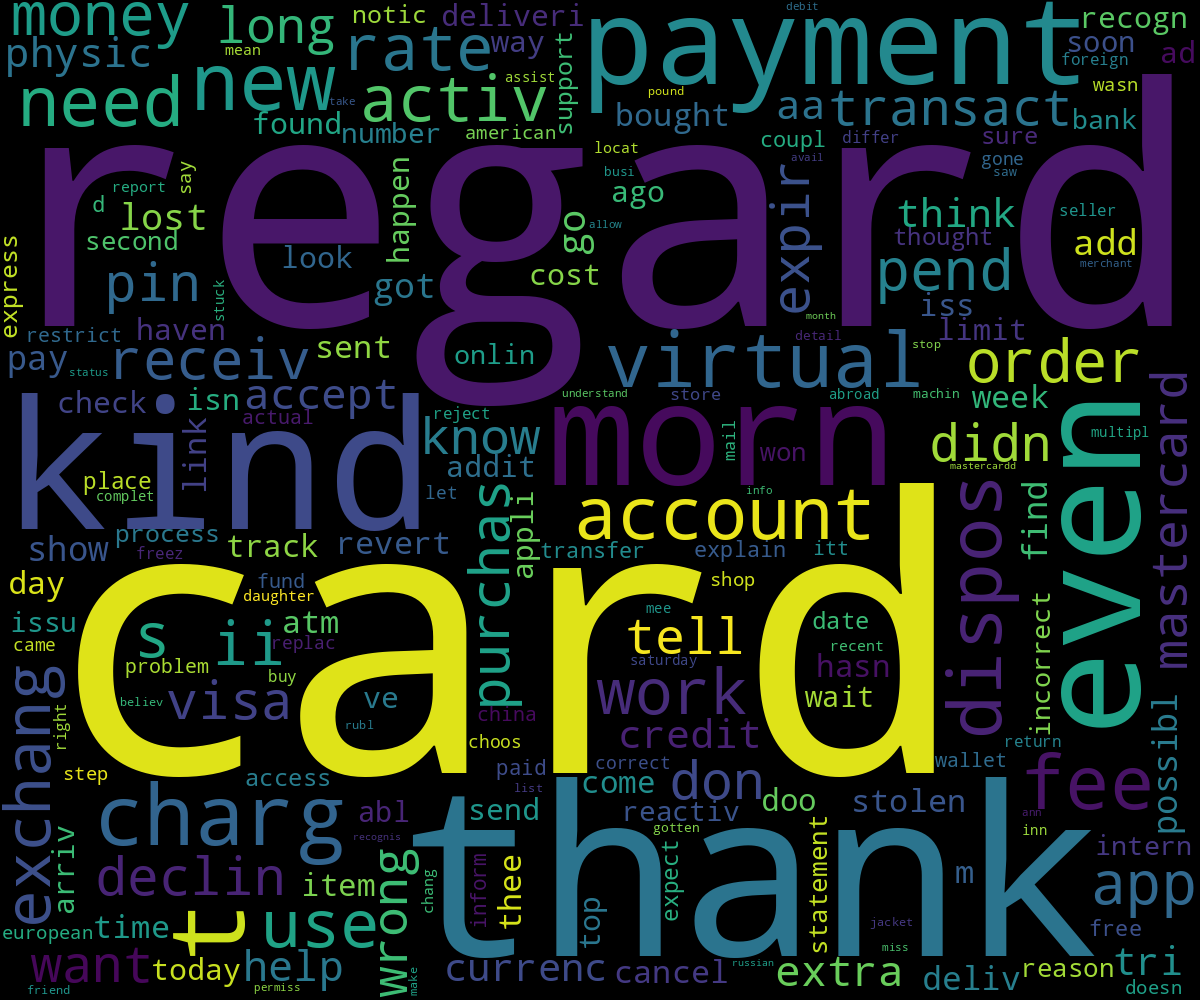

In [13]:
# add stopwords= parameters in the wordcloud

def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in df_preprocess[df_preprocess["class"]=="card"]["text_clean"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

wordcloud_card = wordcloud.words_
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments for card category')


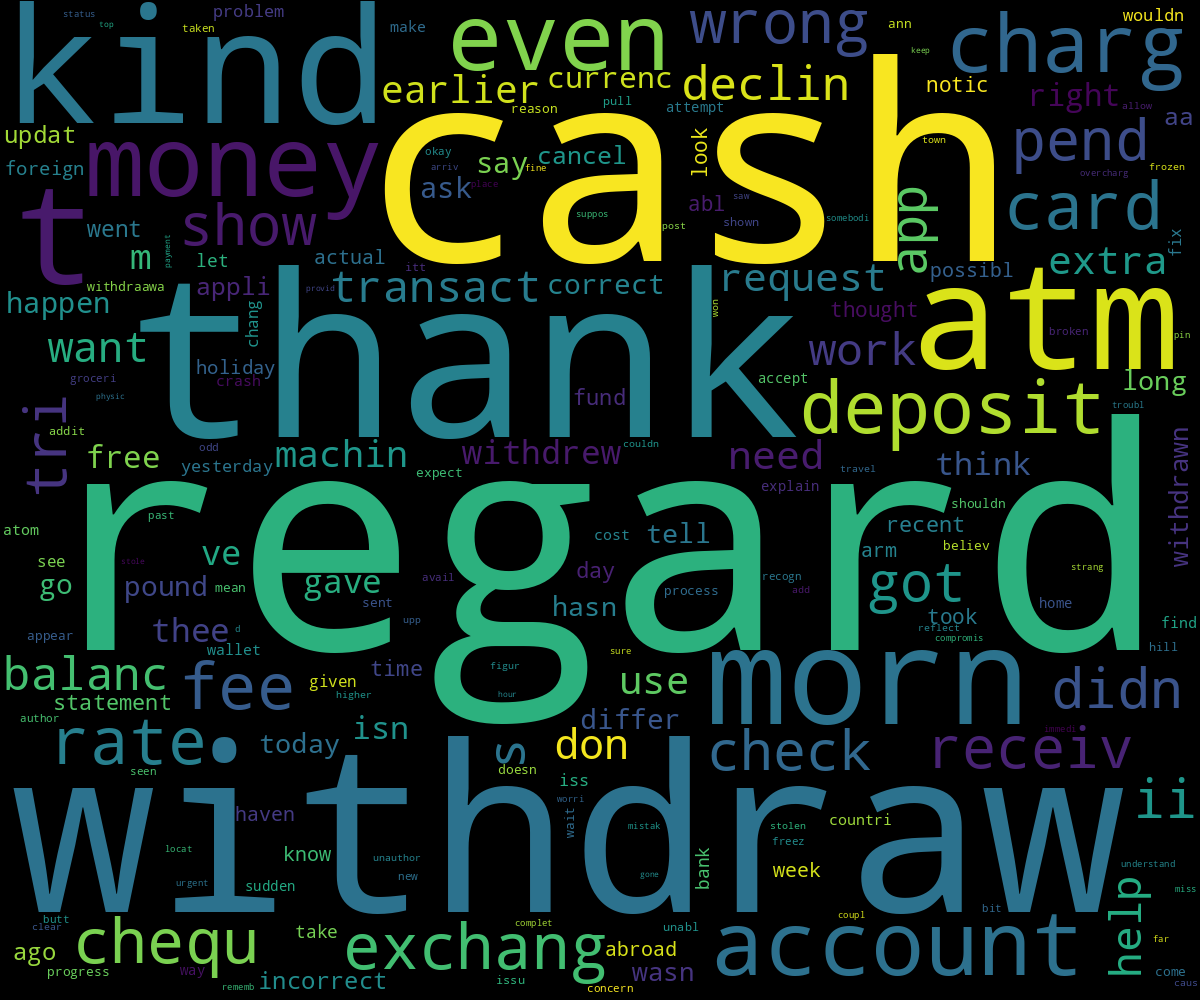

In [14]:
text = ' '.join([nonan(abstract) for abstract in df_preprocess[df_preprocess["class"]=="cash"]["text_clean"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

wordcloud_cash = wordcloud.words_
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments for cash category')


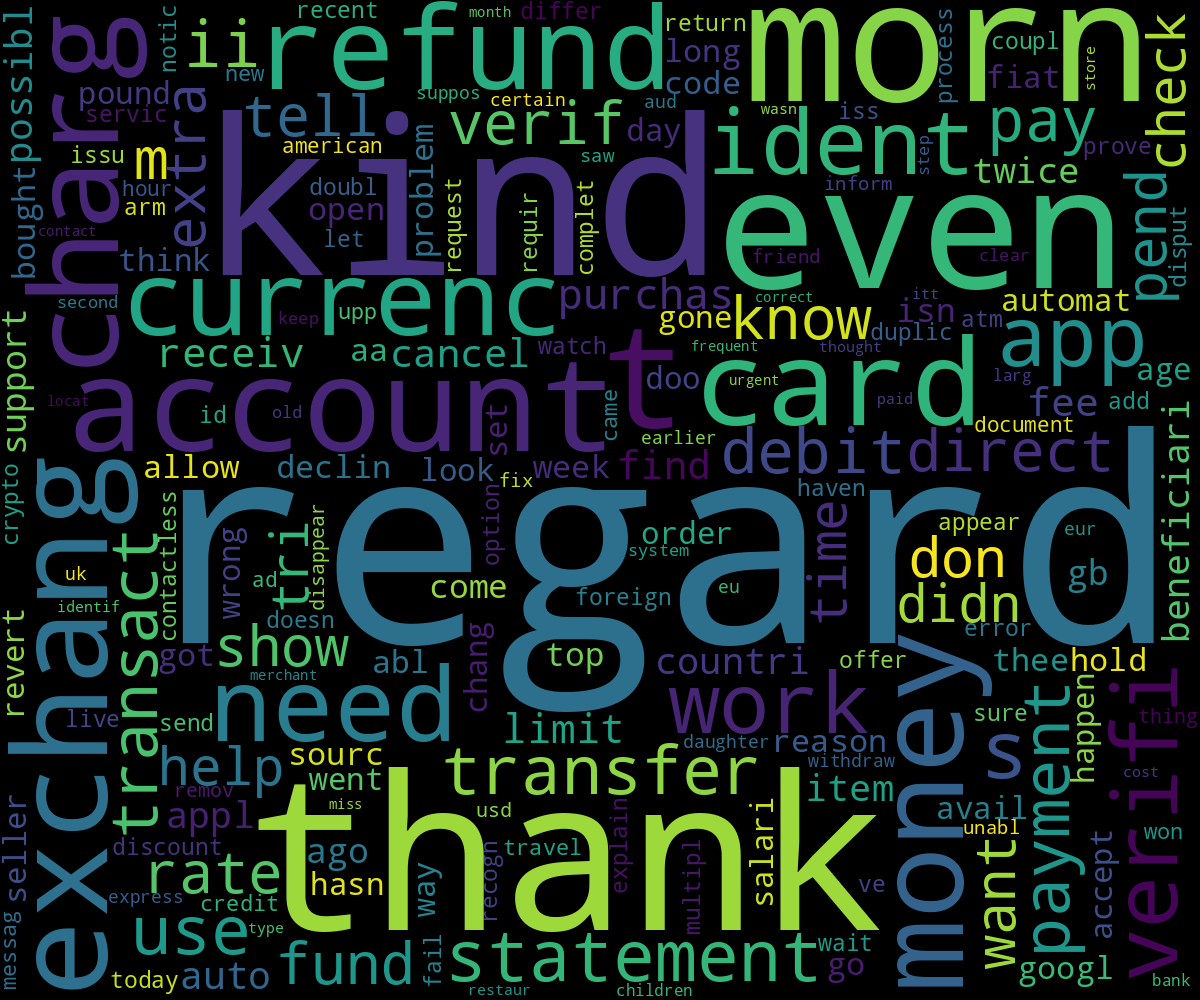

In [15]:
text = ' '.join([nonan(abstract) for abstract in df_preprocess[df_preprocess["class"]=="others"]["text_clean"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

wordcloud_others = wordcloud.words_
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments for others category')


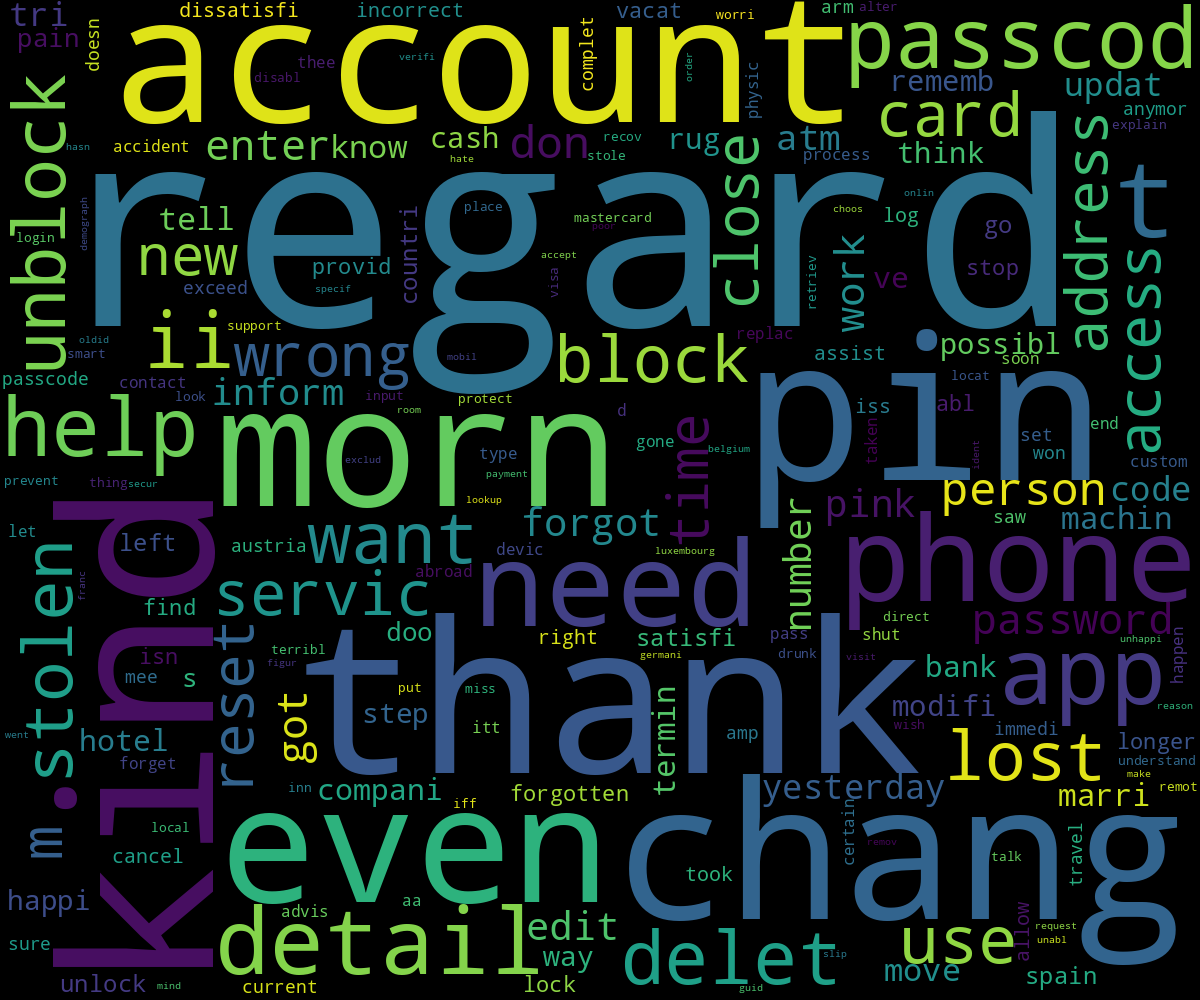

In [16]:
text = ' '.join([nonan(abstract) for abstract in df_preprocess[df_preprocess["class"]=="security"]["text_clean"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

wordcloud_security = wordcloud.words_
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments for security category')


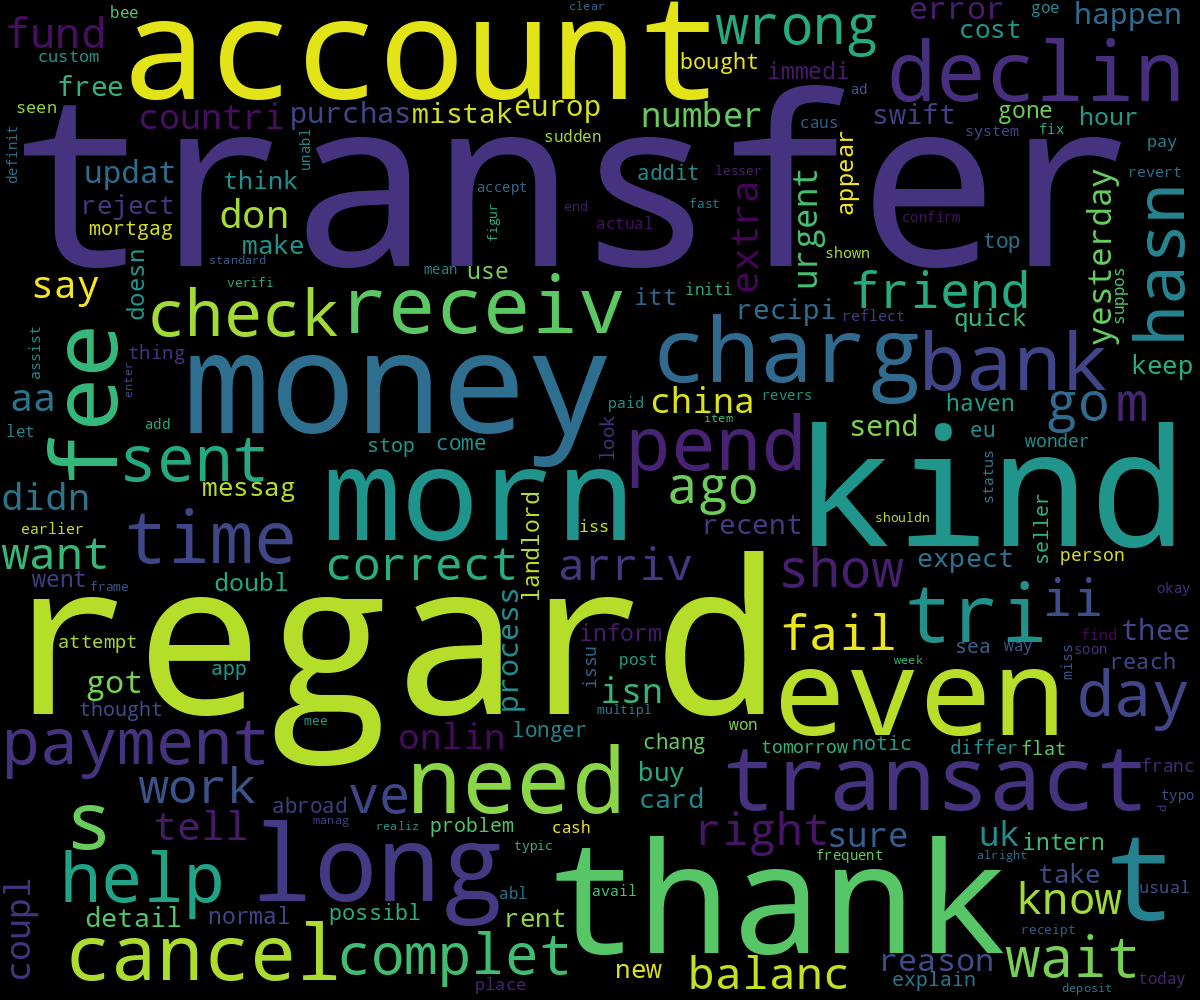

In [17]:
text = ' '.join([nonan(abstract) for abstract in df_preprocess[df_preprocess["class"]=="transfer"]["text_clean"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

wordcloud_transfer = wordcloud.words_
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments for transfer category')

The list of the common wordcloud words between the 5 categories.
This list can be used to add to the stopwords (However only the none useful words like hello, hi, regards..)
However there is words very import like cards to not include in the stopwords

In [18]:
common_keys = set(wordcloud_card.keys()) & set(wordcloud_cash.keys()) & set(wordcloud_others.keys()) & set(wordcloud_security.keys()) & set(wordcloud_transfer.keys())
print(list(common_keys))

['reason', 'won', 'help', 'itt', 'sure', 'thee', 'iss', 'doesn', 'abl', 'miss', 'explain', 'look', 'happen', 'morn', 'isn', 'got', 'aa', 'work', 'tri', 'wrong', 'possibl', 'process', 'hasn', 'know', 'even', 'cancel', 'gone', 'use', 'need', 'card', 'find', 'payment', 's', 'm', 'go', 'don', 'account', 'complet', 'thank', 'tell', 'let', 'chang', 'bank', 'accept', 'think', 'new', 'ii', 'time', 'way', 'kind', 'regard', 've', 'app', 't', 'want']


# Establishing a baseline model

In [19]:
def train_split(df_processed, text=None, label=None):
    
    return train_test_split(df_processed[text], df_processed[label], 
                            test_size=0.2, random_state=42, stratify=df_processed[label])

In [20]:
X_train, X_test, y_train, y_test = train_split(df_preprocess, text='text_clean', label='class')


In [21]:
def baseline_with_tfidf(X_train, X_test, y_train, y_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    """
    
    # pipe = (...)
    # pipe.fit(...)
    # (...)
    
    # YOUR CODE HERE
    # important: only train the vectorizer on the training data (but with pipeline no problems with it)
    # we can use for classifier: MultinomialNB(), SVC(), GradientBoostingClassifier()
    pipe = Pipeline([("Tfidf", TfidfVectorizer()), # ngram_range(1,2) can be added
                    ("classifier", RandomForestClassifier())])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)
    acc = round(accuracy_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'),3) # use "weighted" for umbalanced data otherwise use ="macro"
    precision = round(precision_score(y_test, y_pred, average='weighted'),3)
    recall = round(recall_score(y_test, y_pred, average='weighted'),3)
    
    return pipe, y_pred, y_prob, acc, f1, precision, recall

In [22]:
pipe, y_pred, y_prob, acc, f1, precision, recall = baseline_with_tfidf(X_train, X_test, y_train, y_test)

In [23]:
from sklearn import metrics

def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    labels.sort() # be careful with the order of the label
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    plt.show()

def plot_roc(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
def cm_roc_curve(y_test, y_pred, acc, precision, recall, f1):
    print(f'Accuracy of the model: {np.round(acc*100,2)}%')
    print(f'Precision Score of the model: {np.round(precision*100,2)}%')
    print(f'Recall Score of the model: {np.round(recall*100,2)}%')
    print(f'F1 Score of the model: {np.round(f1*100,2)}%')
    print('-'*50)
    # print(classification_report(y_test,y_pred))
    
    # fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    labels = list(set(y_pred))
    labels.sort()
    ax1 = plot_confusion_matrix(y_test, y_pred, labels)
    # ax2 = plot_roc(y_test, y_pred)

Accuracy of the model: 93.0%
Precision Score of the model: 93.1%
Recall Score of the model: 93.0%
F1 Score of the model: 93.0%
--------------------------------------------------


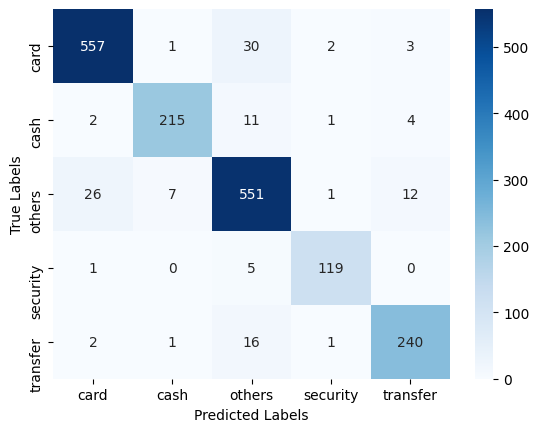

In [25]:
cm_roc_curve(y_test, y_pred, acc, precision, recall, f1)

In [26]:
y_true_bin = label_binarize(y_test, classes=["card", "cash", "others", "security", "transfer"])

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[: ,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [28]:
roc_auc

{0: 0.9868763835973879,
 1: 0.9935840316097827,
 2: 0.9797923003401262,
 3: 0.9992869875222817,
 4: 0.9901933015305108}

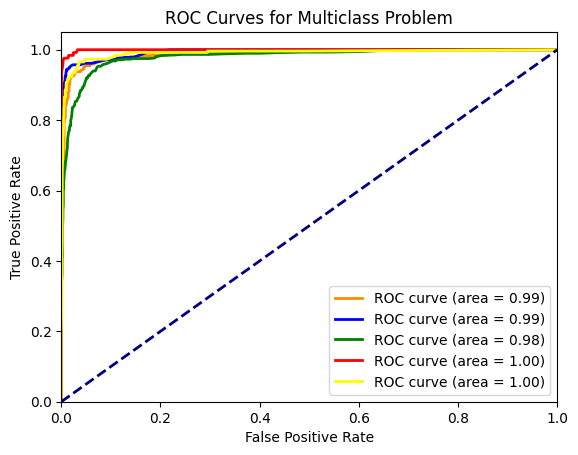

In [29]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='yellow', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Problem')
plt.legend(loc="lower right")
plt.show()

# Submission

In [30]:
#Loading the required data
test_data_path = "data/test_dataset.csv"
maping_path = "data/mapping.csv"
df_test = pd.read_csv(test_data_path)
df_test

text
0                              How do I locate my card?
1                 Why won't my card show up on the app?
2                   I need to know your exchange rates.
3     I purchased something in a foreign currency bu...
4     My statement has a dollar I have been charged ...
...                                                 ...
1037                      Can I use my card in Austria?
1038         Do you have to be in the UK to get a card?
1039                 Can I use this all over the world?
1040      Can I get a card even though I live in the US
1041      Do you provide cards to people not in the UK?

[1042 rows x 1 columns]

In [31]:
df_test['text_clean'] = df_test.text.map(_clean_sentence)
df_test

text  \
0                              How do I locate my card?   
1                 Why won't my card show up on the app?   
2                   I need to know your exchange rates.   
3     I purchased something in a foreign currency bu...   
4     My statement has a dollar I have been charged ...   
...                                                 ...   
1037                      Can I use my card in Austria?   
1038         Do you have to be in the UK to get a card?   
1039                 Can I use this all over the world?   
1040      Can I get a card even though I live in the US   
1041      Do you provide cards to people not in the UK?   

                                    text_clean  
0                                   locat card  
1                               won t card app  
2                       need know exchang rate  
3     purchas foreign currenc rate appli wrong  
4                  statement dollar charg show  
...                                        ...  
1037                          use card austria  
1038                                   uk card  
1039                                 use world  
1040                                 card live  
1041                      provid card peopl uk  

[1042 rows x 2 columns]

to fit all the data 

In [32]:
pipe.fit(df_preprocess["text_clean"], df_preprocess["class"] )

Pipeline(steps=[('Tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [33]:
y_sub = pipe.predict(df_test['text_clean'])
df_sub = pd.DataFrame(y_sub, columns=['class'])
df_sub.to_csv("submissions/sub_1.csv", index=False)